In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

time: 12.7 ms (started: 2025-05-10 17:34:35 +02:00)


In [2]:
!export SSL_CERT_FILE=/etc/ssl/certs/ca-certificates.crt

time: 1.08 s (started: 2025-05-10 17:34:35 +02:00)


In [3]:
import os
os.environ["SSL_CERT_FILE"] = "/etc/ssl/certs/ca-certificates.crt"

time: 15.8 ms (started: 2025-05-10 17:34:36 +02:00)


In [143]:
import pandas as pd
from getpass import getpass
import re  
from datasets import load_dataset
import json
import zipfile
from recommendation_research_data.clanky_entities.entity_db import (
    get_entities as get_entities_clanky)

from recommendation_research_llm_handler.llm_client import LLMHandler
import getpass
from recommendation_content_classifier.utils import (
    plot_confusion_matrix)

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 1000)
pd.set_option("max_colwidth", 100)

time: 3.55 s (started: 2025-05-10 22:39:25 +02:00)


In [5]:
'''
Dataset 1: potsawee/wiki_bio_gpt3_hallucination: accurate, minor_inaccurate, major_inaccurate
Dataset 2: fever
'''
DATASET =  2

time: 27.1 ms (started: 2025-05-10 17:34:38 +02:00)


## Load data

In [ ]:
def add_wikipedia_text(dataset, wiki_dict):
    def enrich(example):
        page = example['evidence_wiki_url']
        example['wiki_info'] = wiki_dict.get(page, None)
        return example

    return dataset.map(enrich)

def filter_missing_wiki(example):
    return example['wiki_info'] is not None


def load_all_wiki_pages(folder_path):
    wiki_dict = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.jsonl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    try:
                        entry = json.loads(line)
                        wiki_dict[entry['id']] = entry['text']
                    except json.JSONDecodeError:
                        continue 

    return wiki_dict

def load_wiki_dict_from_zip(zip_path):
    wiki_dict = {}
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        for filename in zipf.namelist():
            # Check that file is in the wiki-pages/ directory and ends with .jsonl
            if filename.startswith('wiki-pages/') and filename.endswith('.jsonl'):
                with zipf.open(filename) as f:
                    for line in f:
                        try:
                            entry = json.loads(line.decode('utf-8'))
                            wiki_dict[entry['id']] = entry['text']
                        except json.JSONDecodeError:
                            continue  
    return wiki_dict

time: 1min 58s (started: 2025-05-10 21:13:37 +02:00)


In [ ]:
if DATASET == 1:
    df = pd.read_parquet("hf://datasets/potsawee/wiki_bio_gpt3_hallucination/data/evaluation-00000-of-00001-e91191b8ff41afbe.parquet")
    dataset = pd.DataFrame({
    'sentence': df['gpt3_sentences'].explode(),
    'annotation': df['annotation'].explode(),
    'original_text': df['wiki_bio_text'].repeat(df['gpt3_sentences'].str.len())
    }).reset_index(drop=True)
    # dataset.annotation = dataset.annotation.map({'major_inaccurate': 0, 'minor_inaccurate': 1, 'accurate': 2})
elif DATASET == 2:
    dataset = load_dataset("fever", "v1.0")
    zip_file_path = './wiki-pages/wiki-pages.zip'
    wiki_dict = load_wiki_dict_from_zip(zip_file_path)
    
    dataset_with_wiki = add_wikipedia_text(dataset['train'], wiki_dict)
    filtered_dataset = dataset_with_wiki.filter(filter_missing_wiki)
    train_data = pd.DataFrame(filtered_dataset)

time: 2.28 s (started: 2025-05-10 17:46:27 +02:00)


In [154]:
train_data.label.value_counts()

label
SUPPORTS           192405
REFUTES             69570
NOT ENOUGH INFO     47609
Name: count, dtype: int64

time: 81.7 ms (started: 2025-05-10 22:42:47 +02:00)


In [ ]:
# train_data = train_data[train_data['wiki_info'] != '']

time: 138 ms (started: 2025-05-10 22:27:25 +02:00)


# LLM classification

In [8]:
sasanka_token_proxi = getpass.getpass("Enter token for LLM proxi:")

time: 16.3 s (started: 2025-05-10 17:34:41 +02:00)


In [219]:
llm_handler = LLMHandler(api_key=sasanka_token_proxi,temperature=0, model='gpt-4.1-mini')

time: 217 ms (started: 2025-05-14 16:27:49 +02:00)


In [198]:
async def classify_hallucination(prompt):
    response = await llm_handler.async_response(prompt)
    match = re.findall(r'\b(SUPPORTS|REFUTES|NOT ENOUGH INFO)\b', response)
    classification = match[-1] if match else response
    
    return classification

time: 51.8 ms (started: 2025-05-10 23:47:10 +02:00)


## LLM as a judge 

In [220]:
prompt_classify = lambda claim, wiki: f'''
### System
You are an impartial fact-checking classifier.
You receive:
- A natural-language **claim**.
- A chunk of **Wikipedia information** that may contain supporting or contradicting evidence.

Your task:

1. Read the claim and the Wikipedia information carefully.  
2. Decide which single label fits best:
   - **SUPPORTS** - all essential aspects of the claim are directly verified by the information.  
   - **REFUTES** - the information clearly contradicts the claim.  
   - **NOT ENOUGH INFO** - the information is insufficient to determine support or refutation.
3. **Output only one word** — one of the three labels above.  
   Do **not** explain your reasoning, do **not** output anything else.

### User
Claim:
{claim}

Wikipedia_information:
{wiki}

### Assistant
'''

prompt_judge = lambda claim, wiki, pred: f"""
### System
You are an impartial fact-checking judge.  
You receive:
• A natural-language **claim**.  
• A chunk of **Wikipedia information** that may contain supporting or contradicting evidence.  
• A **predicted label** chosen from SUPPORTS, REFUTES, NOT ENOUGH INFO .

Your task:

1. Read the claim and the Wikipedia information carefully.  
2. Determine the *correct* label:
   • **SUPPORTS** - all essential aspects of the claim are directly verified by the information.  
   • **REFUTES**  - the information clearly contradicts the claim.  
   • **NOT ENOUGH INFO** - the information is insufficient to decide either way.  
3. Compare the correct label to the *predicted* label.  
4. **Output only one word**:  
   • If the predicted label is correct, output that label unchanged.  
   • Otherwise, output the correct label you determined.  
Do **not** explain your reasoning, do **not** output anything else.

### User
Claim:
{claim}

Wikipedia_information:
{wiki}

Predicted_label:
{pred}

### Assistant
"""

time: 75.1 ms (started: 2025-05-14 16:27:58 +02:00)


In [211]:
sample = train_data.sample(100)
sample.label.value_counts()

label
SUPPORTS           59
REFUTES            28
NOT ENOUGH INFO    13
Name: count, dtype: int64

time: 92.1 ms (started: 2025-05-14 16:22:03 +02:00)


In [213]:
value_to_set = sample.query('label == "SUPPORTS"')['wiki_info'].iloc[0]
sample.loc[sample['label'] == "NOT ENOUGH INFO", 'wiki_info'] = value_to_set

time: 83.3 ms (started: 2025-05-14 16:22:13 +02:00)


In [221]:
for i, fow in sample.iterrows():
    claim = fow['claim']
    wiki = fow['wiki_info']
    label = fow['label']
    
    prompt = prompt_classify(claim, wiki)
    classification = await classify_hallucination(prompt)
    
    # print(f"Classification: {classification}, Label: {label}")
    sample.loc[i, 'pred'] = classification

time: 1min 24s (started: 2025-05-14 16:28:13 +02:00)


0.89


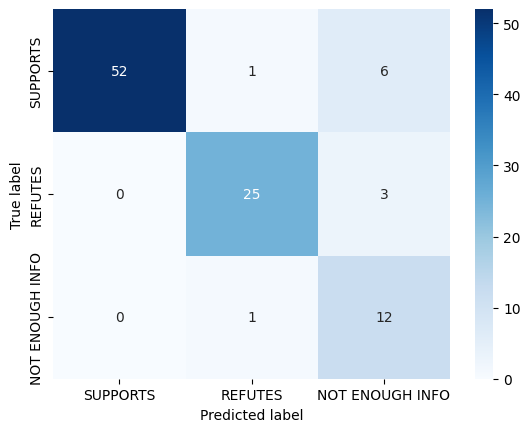

time: 234 ms (started: 2025-05-14 16:30:34 +02:00)


In [222]:
print((sample['pred'] == sample['label']).mean())
plot_confusion_matrix(sample['label'], sample['pred'], labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])

In [223]:
for i, fow in sample.iterrows():
    claim = fow['claim']
    wiki = fow['wiki_info']
    label = fow['label']
    pred = fow['pred']
    
    prompt = prompt_judge(claim, wiki, pred)
    classification = await classify_hallucination(prompt)
    
    # print(f"Classification: {classification}, Label: {label}")
    sample.loc[i, 'pred_judge'] = classification

time: 1min 16s (started: 2025-05-14 16:31:25 +02:00)


0.9


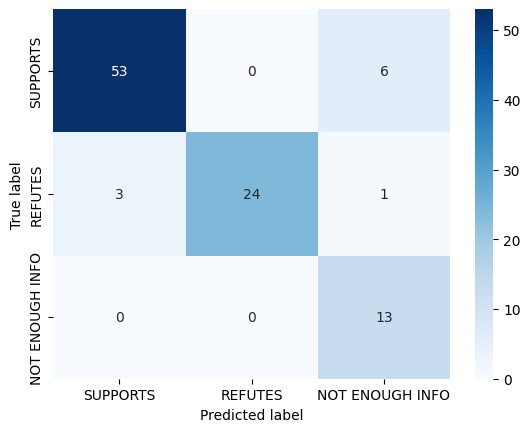

time: 233 ms (started: 2025-05-14 16:33:03 +02:00)


In [224]:
print((sample['pred_judge'] == sample['label']).mean())
plot_confusion_matrix(sample['label'], sample['pred_judge'], labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])

## Evidence-First Decoding

In [89]:
prompt_useful_sentences = lambda wiki: f'''
From the article below, extract 1-3 sentences that are most likely to be useful for verifying factual claims.

[ARTICLE STARTS]
{wiki}
[ARTICLE ENDS]
'''
prompt_evaluate = lambda claim, sentences: f'''
Now evaluate the following claim using sentences:
Claim: {claim}
Evidence:
{sentences}
return only the answer in the format: "SUPPORTS / REFUTES / NOT ENOUGH INFO"
'''

time: 43.4 ms (started: 2025-05-10 21:58:16 +02:00)


In [ ]:
sentences = await llm_handler.async_response(prompt_useful_sentences(sample.query("id == 202110")['wiki_info']))
await classify_hallucination(prompt_evaluate(sample.query("id == 202110")['claim'], sentences)), sample.query("id == 202110")['label'][0]

('NOT ENOUGH INFO',
 48632    REFUTES
 Name: label, dtype: object)

time: 1.78 s (started: 2025-05-10 22:06:31 +02:00)


# Dense Retrieval + Re-ranking

## Dense Retrieval

In [ ]:
# %pip install -q sentence_transformers
from sentence_transformers import SentenceTransformer, util
import torch

dense_model = SentenceTransformer("distiluse-base-multilingual-cased-v1")

def dense_retrieve(claim, wiki_text, top_k=20):
    sentences = wiki_text.split('. ')
    claim_embedding = dense_model.encode(claim, convert_to_tensor=True)
    sentence_embeddings = dense_model.encode(sentences, convert_to_tensor=True)
    scores = util.cos_sim(claim_embedding, sentence_embeddings)[0]
    top_results = torch.topk(scores, k=top_k)
    return [sentences[i] for i in top_results[1]]


time: 2.74 s (started: 2025-05-11 15:41:26 +02:00)


## Cross-Encoder Re-ranker

In [207]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

cross_encoder = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")

def rerank(claim, candidate_sentences, top_k=5):
    inputs = tokenizer([f"{claim} [SEP] {sent}" for sent in candidate_sentences],
                       return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        logits = cross_encoder(**inputs).logits
    scores = logits.squeeze()
    top_indices = torch.topk(scores, k=top_k).indices
    return [candidate_sentences[i] for i in top_indices]


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]


time: 7.02 s (started: 2025-05-11 15:41:10 +02:00)
